In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 불러오기

In [ ]:
from google.colab import files
files.upload()

In [ ]:
nbastat = pd.read_csv('nba_stats_2020_to_2023.csv')
nbastat

# 특징 선택 Pos FG% 3P% TRB AST STL BLK

In [ ]:
nbastat2 = nbastat[['Pos', 'FG%', '3P%', 'TRB', 'AST', 'STL', 'BLK']]

# 결측값 제거

In [ ]:
m = len(nbastat2)
print(m)
nbastat2 = nbastat2.dropna(axis=0)
m = len(nbastat2)
print(m)

2955
2681


# 이상치 제거 PG, SG, SF, PF, C 가 아닌거 제거

In [ ]:
nbastat3 = nbastat2[ (nbastat2['Pos'] == 'C') | (nbastat2['Pos'] == 'PF') |(nbastat2['Pos'] == 'SG') |(nbastat2['Pos'] == 'SF') |(nbastat2['Pos'] == 'PG') ]
m = len(nbastat3)
print(m)

2632


# 변수 설정

In [ ]:
x1 = nbastat3[['FG%']]
x2 = nbastat3[['3P%']]
x3 = nbastat3[['TRB']]
x4 = nbastat3[['AST']]
x5 = nbastat3[['STL']]
x6 = nbastat3[['BLK']]

Y = nbastat3[['Pos']]

In [ ]:
unique = Y.drop_duplicates()
unique

,Pos
0,C
1,PF
4,SG
7,PG
10,SF


In [ ]:
# binary classification yb  C = 1 else 0
# multiclass classification yt C = 2 PF,SF = 1 PG,SG = 0

yb = nbastat3['Pos'].apply(lambda x:1 if x== 'C' else 0)

yt = nbastat3['Pos'].map({'C' : 2 , 'PF' : 1, 'SF' : 1, 'PG' : 0, 'SG':0})

0       1
1       0
2       1
4       0
5       0
       ..
2950    0
2951    0
2952    1
2953    1
2954    1
Name: Pos, Length: 2632, dtype: int64
0       2
1       1
2       2
4       0
5       0
       ..
2950    1
2951    0
2952    2
2953    2
2954    2
Name: Pos, Length: 2632, dtype: int64


# 변수 벡터 설정

In [ ]:
x0 = np.ones((m,1))
Xb = np.c_[x0,x1,x2,x3,x4,x5,x6]

yb = (np.array(yb)).reshape(m,1)

Xb.shape

(2632, 7)

In [ ]:
yb

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

# train - test dataset 분할

In [ ]:
def permutation_split(X,Y,ratio = 0.7,random_state = 1004):
  num_a = int(X.shape[0] * ratio)
  num_b = X.shape[0] - num_a

  np.random.seed(random_state)
  shuffle = np.random.permutation(X.shape[0])

  X = X[shuffle,:]
  Y = Y[shuffle,:]

  Xa = X[:num_a]
  Ya = Y[:num_a]

  Xb = X[num_a:]
  Yb = Y[num_a:]

  return Xa, Xb, Ya, Yb

In [ ]:
Xb_train, Xb_test, Y_train, Y_test = permutation_split(Xb,yb,0.6)

In [ ]:
print(Y_train.shape)
print(Xb_train.shape)

(1579, 1)
(1579, 7)


In [ ]:
# cross entropy 함수
# Nan 조심 0, inf -> epsilon 도입 e ~ 1-e



def loss_CE(y, y_hat):
  epsilon = 1e-15
  y_hat = np.clip(y_hat,epsilon,1-epsilon)
  return -np.mean(y * np.log(y_hat) + (1-y)* np.log(1-y_hat))



In [ ]:
class LogisticRegressionNumpy():    # hyperparameter 입력
  def __init__(self, learning_rate = 0.001, n_iter = 2000):
    self.learning_rate = learning_rate
    self.n_iter = n_iter
    self.theta = None

  def sigmoid(self,z):
    return 1/(1+np.exp(-z))

  def train(self, X, y):
    m, n = X.shape
    self.theta = np.zeros((n,1))

    loss_arr = []

    for i in range(self.n_iter):

      z = X.dot(self.theta)
      y_hat = self.sigmoid(z)

      loss = loss_CE(y,y_hat)
      loss_arr.append(loss)

      gradients = (1/m)*X.T.dot(y_hat - y)

      self.theta = self.theta - self.learning_rate * gradients

    return loss_arr


  def predict(self, X):
      z = X.dot(self.theta)
      y_hat = self.sigmoid(z)

      y_hat_class = [ 1 if i > 0.5 else 0 for i in y_hat]
      return y_hat_class


In [ ]:
model = LogisticRegressionNumpy(learning_rate = 0.1, n_iter = 100000)

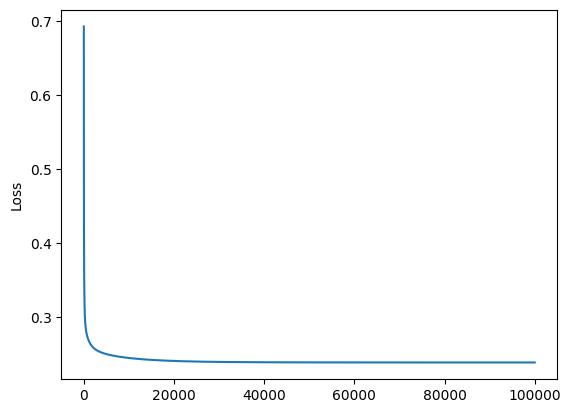

In [ ]:
loss_arr = model.train(Xb_train, Y_train)
plt.plot(loss_arr)
plt.ylabel('Loss')
plt.show()


In [ ]:
pred = model.predict(Xb_train)

cnt = 0
for i in range(len(pred)):
  cnt += (pred[i] == Y_train[i])
print(100 * cnt/len(pred))

pred = model.predict(Xb_test)

cnt = 0
for i in range(len(pred)):
  cnt += (pred[i] == Y_train[i])
print(100 * cnt/len(pred))


[90.6269791]
[73.69420703]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class LogisticRegressionPytorch (nn.Module):
  def __init__(self,input_size):
    super(LogisticRegressionPytorch,self).__init__()
    self.linear = nn.Linear(input_size,1)
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    y_hat = self.sigmoid(self.linear(x))
    return y_hat
  def predict(self,x):
    y_hat = self.forward(x)
    return [ 1 if i > 0.5 else 0 for i in y_hat]


In [ ]:
def train(model, X, y , learning_rate = 0.001,n_iter = 10000):
  criterion = nn.BCELoss()
  optimizer = optim.SGD(model.parameters(),lr=learning_rate)

  X = torch.tensor(X,dtype=torch.float32)
  y = torch.tensor(y,dtype=torch.float32).view(-1,1)

  loss_arr = []
  for i in range(n_iter):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output,y)
    loss_arr.append(loss)

    # gradients = (1/m)*X.T.dot(y_hat - y)
    loss.backward()
    # self.theta = self.theta - self.learning_rate * gradients
    optimizer.step()
  return loss_arr


In [ ]:
model2 = LogisticRegressionPytorch(input_size=7)
loss_arr = train(model2,Xb_train,Y_train,learning_rate = 0.1, n_iter = 10000)

In [ ]:
X = torch.tensor(Xb_train,dtype=torch.float32)

pred = model2.predict(X)

cnt = 0
for i in range(len(pred)):
  cnt += (pred[i] == Y_train[i])
print(100 * cnt/len(pred))

X = torch.tensor(Xb_test,dtype=torch.float32)
pred = model2.predict(X)

cnt = 0
for i in range(len(pred)):
  cnt += (pred[i] == Y_train[i])
print(100 * cnt/len(pred))

[90.50031666]
[73.59924027]
